# Motion planning by learning the solution manifold in trajectory optimization
by Takayuki Osa


In [58]:
# !pip install matplotlib numpy

#### Hyperparamters

In [59]:
alpha = 10

#### Problem Formulation

In [60]:
# from mpl_toolkits.mplot3d import Axes3D  # Not needed with Matplotlib 3.6.3
import matplotlib.pyplot as plt
import numpy as np
import random

random.seed(42)

def shaping_func(r):
    r_max = np.max(r)
    r_med = np.median(r)
    return np.exp(alpha*(r - r_max)/(r_max - r_med)) if (r >= r_med).any() else 0
    # return np.exp(alpha*(r - r_max)/(r_max - r_med)) if np.greater_equal(r, r_med).any() else 0

def shaping_func_lsmo(r):
    return np.exp(alpha*(r))

#### Functions
The paper plots four (4) non-convex equations. The figure plots the range x<sub>1</sub> &in; [0, 2] and x<sub>2</sub> &in; [0, 2].

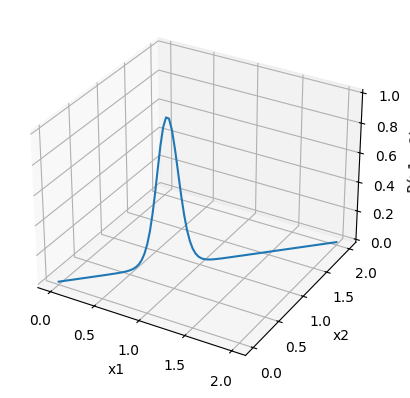

In [61]:
fig = plt.figure(figsize=plt.figaspect(1))  # Square figure
ax = fig.add_subplot(111, projection='3d')

x1 = np.linspace(0, 2, 100)
x2 = np.linspace(0, 2, 100)

def d(eq):
    return np.exp(-2*eq)

def r1(x1, x2):
    if np.less(x1, 0.5).any():
        return d(((x2 - 1.05)**2 + (x1 - 0.5)**2)**0.5)        
    elif np.greater_equal(x1, 1.5).any():
        return d(((x2 - 0.75)**2 + (x1 - 1.5)**2)**0.5)
    else:
        return d(abs(-0.3*x1 - x2 + 1.2) / 1.09**2)

def r2(x1, x2):
    return d(abs((x2 - 1.5)**2 + (x1 + 1)**2 - 2.5))

# print (np.greater_equal(x1, 1.4))

def r3(x1, x2):
    if np.less(x1, 0.7).any():
        return d(((x2 - 0.94)**2 + (x1 - 0.7)**2)**0.5 + 0.2*x2 + 0.14)
    elif np.greater_equal(x1, 1.4).any():
        return d(((x2 - 1.08)**2 + (x1 - 1.4)**2)**0.5 + 0.2*x2 + 0.14)
    else:
        return d((abs(0.2*x1 - x2 + 0.8)/1.04**2) + 0.2*x2 + 0.14)

def r4(x1, x2):
    return d(abs((x2 - 1)**2 + (x1 - 1)**2 - 0.5))

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('R(x1, x2)')

# ax.plot_surface(x1, x2, r1(x1, x2))
plt.plot(x1, x2, shaping_func(r1(x1, x2)))
# plt.plot(x1, x2, shaping_func(r2(x1, x2)))
# plt.plot(x1, x2, shaping_func(r3(x1, x2)))
# plt.plot(x1, x2, shaping_func(r4(x1, x2)))

# # Uncommnet for top view
# ax.elev = 90
# ax.azim = 90

# plt.show()

#### Algorithm 1. Abstract of Learning the Solution Manifold in Optimization (LSMO)
Input:  Objective function R(x), proposal distribution p<sup>prop</sup>(x), shaping function f\
Output: x*

##### Traning phase
1. Generate N synthetic samples {x<sub>i</sub>}<sup>N</sup><sub>i=1</sub> from the proposal distribution p<sup>prop</sup>(x)
2. Evaluate the objective function R(x<sub>i</sub>) and compute the weight f(R(x<sub>i</sub>)) for i = 1,...,N
3. Train p<sub>&theta;</sub>(x|z) by maximizing $\mathcal{L}$(**&theta;**|**&Psi;**) in Eq. (12)
##### Generation phase
4. Generate x<sup>*</sup> with p<sub>&theta;</sub>(x|z) by specifying the value of z
5. (Optional) Fine-tune x<sup>*</sup> with a gradient-based method

Return: x<sup>*</sup>

##### Step 1: Generate N synthetic samples {x<sub>i</sub>}<sup>N</sup><sub>i=1</sub> from the proposal distribution p<sup>prop</sup>(x)

x1:  [1.18827953 1.4296607  0.96515953 0.06176521 0.86263934 0.19641021
 0.03610531 1.24410145 0.49863875 1.82686284] 
x2:  [0.63522114 0.77714107 0.46269571 0.95550481 0.60581598 0.84009671
 0.36677797 0.06425789 1.16350403 1.00553918]


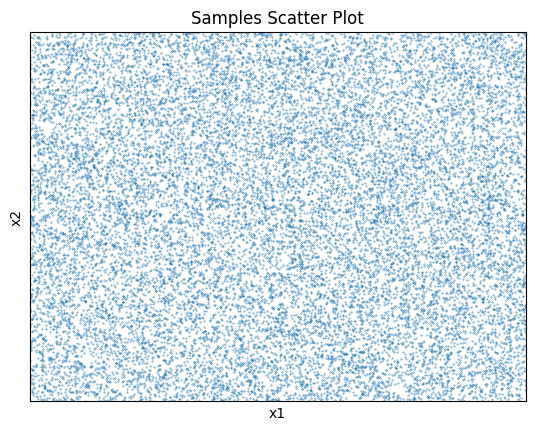

In [62]:
# import numpy as np
# import matplotlib.pyplot as plt
from scipy.interpolate import griddata


num_samples = 20000

samples = np.random.uniform(0, 2, num_samples)
sample_x1 =samples[0:num_samples]
sample_x2 =samples[num_samples::-1]

print("x1: ", sample_x1[0:10], "\nx2: ", sample_x2[0:10])

plt.scatter(sample_x1,sample_x2, s=0.1)
plt.title('Samples Scatter Plot')
plt.xlabel('x1')
plt.ylabel('x2')

plt.xticks([])  
plt.yticks([])

plt.xlim(0,2)
plt.ylim(0,2)

# Show the plot
plt.show()

##### Step 2: Evaluate the objective function R(x<sub>i</sub>) and compute the weight f(R(x<sub>i</sub>)) for i = 1,...,N

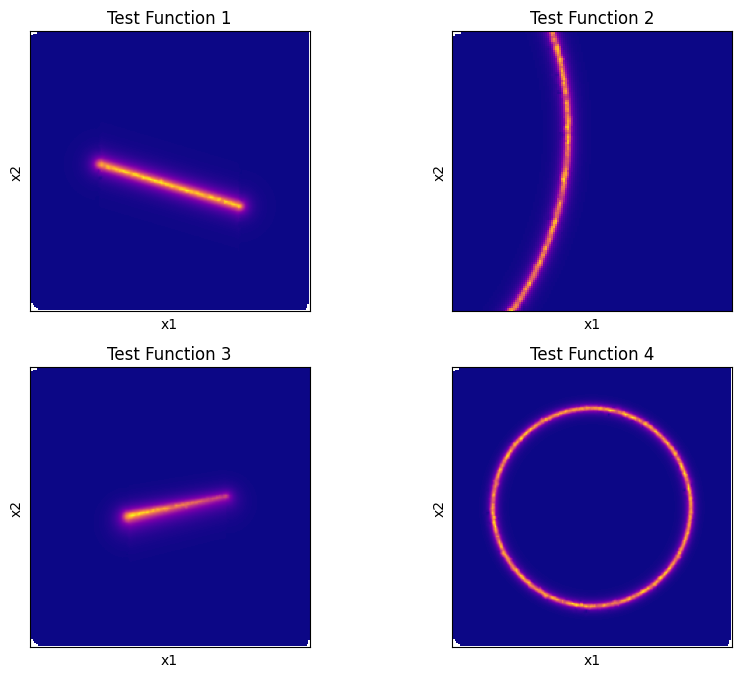

In [63]:
f1, f2, f3, f4 = [], [], [], []

x = sample_x1
y = sample_x2

for i in range(len(sample_x1)):
    r1_out = r1(sample_x1[i],sample_x2[i])
    f1.append(r1_out)
     
    r2_out = r2(sample_x1[i],sample_x2[i])
    f2.append(r2_out)
 
    r3_out = r3(sample_x1[i],sample_x2[i])
    f3.append(r3_out)
     
    r4_out = r4(sample_x1[i],sample_x2[i])
    f4.append(r4_out)

intensity1, intensity2, intensity3, intensity4 = shaping_func(f1), shaping_func(f2), shaping_func(f3),shaping_func(f4)  # Intensity values

# Uncomment for f(R(x)) = exp(alpha * R(x))
# for i in range(len(sample_x1)):
#     r1_out = r1(sample_x1[i],sample_x2[i])
#     f1.append(shaping_func_lsmo(r1_out))
     
#     r2_out = r2(sample_x1[i],sample_x2[i])
#     f2.append(shaping_func_lsmo(r2_out))
 
#     r3_out = r3(sample_x1[i],sample_x2[i])
#     f3.append(shaping_func_lsmo(r3_out))
     
#     r4_out = r4(sample_x1[i],sample_x2[i])
#     f4.append(shaping_func_lsmo(r4_out))

# intensity1, intensity2, intensity3, intensity4 = f1, f2, f3, f4  # Intensity values


# Define grid
grid_x, grid_y = np.mgrid[0:10:1000j, 0:10:1000j]

# Interpolate the intensity values on the grid
grid_z1 = griddata((x, y), intensity1, (grid_x, grid_y), method='cubic')
grid_z2 = griddata((x, y), intensity2, (grid_x, grid_y), method='cubic')
grid_z3 = griddata((x, y), intensity3, (grid_x, grid_y), method='cubic')
grid_z4 = griddata((x, y), intensity4, (grid_x, grid_y), method='cubic')

# Create a figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

# Plot the density map
################################################################################# FUNTCION1
ax1.imshow(grid_z1.T, cmap='plasma')
# Add title and labels
ax1.set_title('Test Function 1')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')

# disabling xticks, yticks by Setting xticks, yticks to an empty list
ax1.set_xticks([])  
ax1.set_yticks([])

ax1.set_xlim(0, 200)
ax1.set_ylim(0, 200)

################################################################################# FUNTCION2
ax2.imshow(grid_z2.T, cmap='plasma')
# Add title and labels
ax2.set_title('Test Function 2')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')

# disabling xticks, yticks by Setting xticks, yticks to an empty list
ax2.set_xticks([])  
ax2.set_yticks([])

ax2.set_xlim(0, 140)
ax2.set_ylim(60, 200)

################################################################################# FUNTCION3
ax3.imshow(grid_z3.T, cmap='plasma')
# Add title and labels
ax3.set_title('Test Function 3')
ax3.set_xlabel('x1')
ax3.set_ylabel('x2')

# disabling xticks, yticks by Setting xticks, yticks to an empty list
ax3.set_xticks([])  
ax3.set_yticks([])

ax3.set_ylim(0, 200)
ax3.set_xlim(0, 200)

################################################################################# FUNTCION3
ax4.imshow(grid_z4.T, cmap='plasma')
# Add title and labels
plt.title('Test Function 4')
plt.xlabel('x1')
plt.ylabel('x2')

# disabling xticks, yticks by Setting xticks, yticks to an empty list
plt.xticks([])  
plt.yticks([])
# plt.colorbar(label='Intensity')

ax4.set_ylim(0, 200)
ax4.set_xlim(0, 200)

# Show the plot
plt.show()


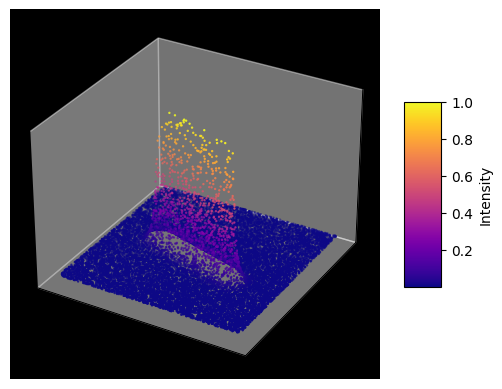

In [64]:
from mpl_toolkits.mplot3d import Axes3D

# Create a figure and a 3D subplot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data with an intensity map
sc = ax.scatter(sample_x1, sample_x2, intensity1, c=intensity1, cmap='plasma', s=0.5)

# Add a color bar to show the intensity scale
colorbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=5)
colorbar.set_label('Intensity')

# Set labels for axes
# ax.set_xlabel('Sample X1')
# ax.set_ylabel('Sample X2')
# ax.set_zlabel('Intensity 1')
ax.grid(False)
ax.set_xticks([])  
ax.set_yticks([])
ax.set_zticks([])
ax.set_facecolor('black')

# Show the plot
plt.show()

In [65]:
## We assume the proposal distribution is uniform

# from scipy.integrate import quad

# partition_func, error = quad(shaping_func, -2, 2)
# p_target = np.divide(shaping_func_lsmo(f1_shape), partition_func)
# print (p_target)
# p_prop = np.random.normal(-2, 2, num_samples)
# weight = np.divide(p_target, p_prop)

# print(weight[:20])

##### Step 3: Train p<sub>&theta;</sub>(x|z) by maximizing $\mathcal{L}$(**&theta;**|**&Psi;**) in Eq. (12)

In [66]:
import torchvision
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, data_type='binary'):
        super(VAE, self).__init__()

        # Encoder: layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, latent_size)
        self.fc22 = nn.Linear(hidden_size, latent_size)

        # Decoder: layers
        self.fc3 = nn.Linear(latent_size, hidden_size)
        self.fc41 = nn.Linear(hidden_size, input_size)
        self.fc42 = nn.Linear(hidden_size, input_size)

        self.data_type = data_type

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        mean, log_var = self.fc21(h1), self.fc22(h1)
        return mean, log_var
    
    @staticmethod
    def reparameterize(mean, log_var):
        mu, sigma = mean, torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        return z
    
    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        if self.data_type == "real":
            mean, log_var = torch.sigmoid(self.fc41(h3)), self.fc42(h3)
            return mean, log_var
        else:
            logits = self.fc41(h3)
            probs = torch.sigmoid(logits)
            return probs
         
    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.reparameterize(z_mean, z_logvar)
        return z_mean, z_logvar, self.decode(z)

In [67]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import norm


def make_gif(imgs_dir, num_imgs, t=100):
    imgs = []
    for i in range(num_imgs):
        img_name = '{}/samples-{}.png'.format(imgs_dir, i)
        temp = Image.open(img_name)
        imgs.append(temp)
    imgs[0].save(fp=os.path.join(imgs_dir, 'samples-gif.gif'), save_all=True, append_images=imgs, duration=t, loop=0)
    print('GIF done!')


def plot_elbocurve(train_elbo, test_elbo, latent_size, save_dir):
    train_elbo = np.array(train_elbo)
    test_elbo = np.array(test_elbo)
    plt.plot(train_elbo, color='b', linestyle='-', label='train')
    plt.plot(test_elbo, color='r', linestyle='-', label='test')
    plt.legend(loc='best')
    plt.xlabel('Epoch')
    plt.ylabel('Lower Bound')
    plt.title('FreyFace, $N_z$={}'.format(latent_size))
    plt.savefig(os.path.join(save_dir, 'elbocurve-{}D.png'.format(latent_size)))
    print('ELBO-curve done!')


In [80]:
!pip  install tqdm

In [84]:
import torch
import torchvision
from models import VAE
import os
from torchvision.utils import save_image
from tqdm.notebook import trange, tqdm

os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_samples = num_samples
coeff_cap = 0.1 # gamma
learning_rate = 0.001
num_epochs = 350
batch_size = 250
hidden_layers = 64
latent_size =1
info_cap = np.linspace(0, 5, num_epochs)

def compute_elbo(x, reconst_x, mean, log_var):
    # ELBO(Evidence Lower Bound) is the objective of VAE, we train the model just to maximize the ELBO.
    x =  torch.sigmoid(x)
    reconst_error = -torch.nn.functional.binary_cross_entropy(reconst_x, x, reduction='sum')
    # see Appendix B from VAE paper: "Kingma and Welling. Auto-Encoding Variational Bayes. ICLR-2014."
    # -KL[q(z|x)||p(z)] = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    print (kl_divergence)
    elbo = (reconst_error - kl_divergence) / len(x)
    return elbo

input = np.array([[x, y, z] for x, y, z in zip(sample_x1, sample_x2, intensity1)])
input = torch.Tensor(input)
# output = torch.Tensor(np.array(intensity1))
print(f"Shape: {input.shape} \nType: {type(input)}")
print (input[0])


train_size = int(0.8 * len(input))
test_size = len(input) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(input, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(dataset=input.reshape(3,num_samples), batch_size=num_samples, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=input.reshape(3,num_samples), batch_size=num_samples, shuffle=False)

data_type = 'binary'

model = VAE(num_samples, hidden_layers, latent_size).to('cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_elbo = []
test_elbo = []

for epoch in range(1, num_epochs + 1):
    for batch_idx, val in tqdm(enumerate(train_loader)):
        # forward pass
        batch_data = val.to('cpu')
        batch_mean, batch_logvar, reconst_batch = model(batch_data)
        aver_loss = -compute_elbo(batch_data, reconst_batch, batch_mean, batch_logvar)
        # backprop and optimize
        optimizer.zero_grad()
        aver_loss.backward()
        optimizer.step()
        
        if (batch_idx + 1) % 100 == 0:
            print('Epoch {}/{}, Batch {}/{}, Aver_Loss: {:.2f}'.format(
                epoch, num_epochs, batch_idx + 1, math.ceil(len(train_dataset) / batch_size), aver_loss.item()))

        with torch.no_grad():
        # elbo_curve on training-set
            total_elbo = 0
            for batch_idx, batch_x in enumerate(train_loader):
                batch_data = batch_x.to('cpu')
                batch_mean, batch_logvar, reconst_batch = model(batch_data)
                total_elbo += compute_elbo(batch_data, reconst_batch, batch_mean, batch_logvar).item()
            aver_elbo = total_elbo / (batch_idx + 1)
            train_elbo.append(aver_elbo)
           
            # elbo_curve on test-set
            total_elbo = 0
            for batch_idx, batch_x in enumerate(test_loader):
                batch_data = batch_x.to('cpu')
                batch_mean, batch_logvar, reconst_batch = model(batch_data)
                total_elbo += compute_elbo(batch_data, reconst_batch, batch_mean, batch_logvar).item()
            aver_elbo = total_elbo / (batch_idx + 1)
            test_elbo.append(aver_elbo)

# Save the trained model's parameters
paras_dir = 'trained_parameters'
if not os.path.exists(paras_dir):
    os.makedirs(paras_dir)
torch.save(model.state_dict(), os.path.join(paras_dir, 'mnist_zdim{}.pkl'.format(latent_size)))

Shape: torch.Size([20000, 3]) 
Type: <class 'torch.Tensor'>
tensor([1.1883, 0.6352, 0.0093])


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [74]:
z_val = np.linspace(-1.64,1.64,100)

def produce_z_values(num_samples):
    return np.linspace(-1.64, 1.64, num_samples)

# Build the model and recover the trained model parameters
model_2D = VAE(input_size=20000, hidden_size=64, latent_size=1).to('cpu')
model_2D.load_state_dict(torch.load(os.path.join(paras_dir, 'mnist_zdim1.pkl')))
print (model_2D)

# ========================= Experiment 1: Visualization of Learned MNIST Manifold ========================= #

z_values = produce_z_values(100)
z_values = torch.from_numpy(z_values).float()

VAE(
  (fc1): Linear(in_features=20000, out_features=64, bias=True)
  (fc21): Linear(in_features=64, out_features=1, bias=True)
  (fc22): Linear(in_features=64, out_features=1, bias=True)
  (fc3): Linear(in_features=1, out_features=64, bias=True)
  (fc41): Linear(in_features=64, out_features=20000, bias=True)
  (fc42): Linear(in_features=64, out_features=20000, bias=True)
)


In [ ]:
class VAE(nn.Module):

    def __init__(self, input_dim=2, hidden_dim=hidden_layers, latent_dim=hidden_layers_dim, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, log_var
        
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.decode(z)  
        return x_hat, mean, log_var

: 

In [ ]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

: 

In [ ]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss - coeff_cap*np.abs(KLD - )

: 

In [ ]:
# def loss_function(x, x_hat, mean, log_var):
#     reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
#     KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

#     return reproduction_loss + KLD

: 

In [ ]:
def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

: 

In [ ]:
train(model, optimizer, epochs=50, device=device)

: 

In [ ]:
# def plot_results:

: 

##### Step 4: Evaluate the objective function R(x<sub>i</sub>) and compute the weight f(R(x<sub>i</sub>)) for i = 1,...,Generate x<sup>*</sup> with p<sub>&theta;</sub>(x|z) by specifying the value of z

: 

##### Step 5: (Optional) Fine-tune x<sup>*</sup> with a gradient-based method

In [ ]:
#TODO

: 

#### Variational Autoencoder


In [ ]:
!pip install torchvision
# Code from https://colab.research.google.com/gist/rekalantar/2c303b69a11875dfba873aac11e44cfd/variationalautoencoder_pytorch.ipynb#scrollTo=bwWtxYrUF826

: 

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim=784, hidden_dim=512, latent_dim=256):
        super(Encoder, self).__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear (hidden_dim, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True
        
    def forward(self, x):
        x = self.LeakyReLU(self.linear1(x))
        x = self.LeakyReLU(self.linear2(x))

        mean = self.mean(x)
        log_var = self.var(x)                     
        return mean, log_var

: 

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, output_dim=784, hidden_dim=512, latent_dim=256):
        super(Decoder, self).__init__()

        self.linear2 = nn.Linear(latent_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.LeakyReLU(self.linear2(x))
        x = self.LeakyReLU(self.linear1(x))
        
        x_hat = torch.sigmoid(self.output(x))
        return x_hat

: 

In [ ]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, log_var
        
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.decode(z)  
        return x_hat, mean, log_var

: 

In [ ]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

: 

In [ ]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

: 

In [ ]:
def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

: 

In [ ]:
train(model, optimizer, epochs=50, device=device)

: 